In [3]:
# load datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# Load dataset
file_path_= r"C:\Users\u1246538\Downloads\liss-data\Notebooks_MHI-5\merged_dataset2022.csv"
df = pd.read_csv(file_path_)  


# Define the target variable
target_column = 'mhi5_class_2022'  

df = df.dropna(subset=[target_column])
print("Number of missing values in target after cleaning:", df[target_column].isnull().sum())








Number of missing values in target after cleaning: 0


In [5]:
# Define columns that may only be needed for error analysis
possible_error_analysis_columns = ['gender', 'Religion', 'Religious_Membership', 'political_interest', 'mhi5_std_score_2022', 'nomem_encr', 'Ethnic_Background']

# Separate features and target
X = df.drop(columns=[target_column] + possible_error_analysis_columns)  # Drop target + uncertain columns
y = df[target_column]  # Target variable

In [7]:
# Split the data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Check for missing values in the dataset
nan_counts = X.isna().sum()

# Display the columns with NaN values and their counts
print("Columns with NaN values and their counts:")
print(nan_counts[nan_counts > 0])


Columns with NaN values and their counts:
used_hallucinogens                       2
SmallSnacks_Daily                        3
LargeSnacks_Weekly                       3
social_media_frequency                   9
education                                2
self_esteem                              1
composite_values                         1
Health_Hindrance_to_Daily_Functioning    1
Sleeping_Problems                        1
Personal_Net_Income_Category             2
dtype: int64


In [11]:
# For Likert scale responses
X['self_esteem'] = X['self_esteem'].fillna(X['self_esteem'].median())
X['composite_values'] = X['composite_values'].fillna(X['composite_values'].median())

# For categorical variables
X['education'] = X['education'].fillna(X['education'].mode()[0])
X['Personal_Net_Income_Category'] = X['Personal_Net_Income_Category'].fillna(X['Personal_Net_Income_Category'].mode()[0])

# For count-based variables
X['used_hallucinogens'] = X['used_hallucinogens'].fillna(0)
X['SmallSnacks_Daily'] = X['SmallSnacks_Daily'].fillna(0)
X['LargeSnacks_Weekly'] = X['LargeSnacks_Weekly'].fillna(0)
X['social_media_frequency'] = X['social_media_frequency'].fillna(X['social_media_frequency'].mode()[0])
X['Health_Hindrance_to_Daily_Functioning'] = X['Health_Hindrance_to_Daily_Functioning'].fillna(0)
X['Sleeping_Problems'] = X['Sleeping_Problems'].fillna(0)




In [13]:
import numpy as np

# Check missing values per column in X_train and X_test
print("NaNs in each column of X_train:")
print(X_train.isnull().sum())
print("\nNaNs in each column of X_test:")
print(X_test.isnull().sum())

# Manually impute missing values for numeric columns in X_train
for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        # If numeric, fill with the median
        if np.issubdtype(X_train[col].dtype, np.number):
            X_train[col] = X_train[col].fillna(X_train[col].median())
        else:
            # If non-numeric, fill with the mode
            X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
            
# Repeat for X_test
for col in X_test.columns:
    if X_test[col].isnull().sum() > 0:
        if np.issubdtype(X_test[col].dtype, np.number):
            X_test[col] = X_test[col].fillna(X_test[col].median())
        else:
            X_test[col] = X_test[col].fillna(X_test[col].mode()[0])




NaNs in each column of X_train:
used_hallucinogens                       2
SmallSnacks_Daily                        1
LargeSnacks_Weekly                       1
social_media_frequency                   7
sex                                      0
age                                      0
marital_status                           0
living_arrangement                       0
education                                2
extraversion                             0
agreeableness                            0
conscientiousness                        0
emotional_stability                      0
intellect_imagination                    0
self_esteem                              1
composite_values                         1
Self-Rated_Health                        0
Health_Hindrance_to_Daily_Functioning    1
Sleeping_Problems                        1
Personal_Net_Income_Category             1
Employment_status                        0
loneliness_score                         0
hours_on_social_media 

In [15]:
# Verify that there are no NaNs left
print("Total NaNs in X_train after imputation:", X_train.isnull().sum().sum())
print("Total NaNs in X_test after imputation:", X_test.isnull().sum().sum())



Total NaNs in X_train after imputation: 0
Total NaNs in X_test after imputation: 0


In [17]:
# Now, you should be able to fit your LassoCV model without encountering NaN errors
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Get the coefficients of the features
coefficients = lasso.coef_
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})
selected_features_lasso = coef_df[coef_df['Coefficient'] != 0]

print("Selected features using Lasso:")
print(selected_features_lasso)

Selected features using Lasso:
                                  Feature  Coefficient
3                  social_media_frequency     0.005383
5                                     age    -0.003432
6                          marital_status    -0.003713
7                      living_arrangement    -0.010793
12                    emotional_stability    -0.160371
13                  intellect_imagination     0.011145
14                            self_esteem    -0.057439
16                      Self-Rated_Health    -0.036802
17  Health_Hindrance_to_Daily_Functioning     0.059507
18                      Sleeping_Problems     0.127610
19           Personal_Net_Income_Category     0.001613
20                      Employment_status     0.003080
22                  hours_on_social_media    -0.000562


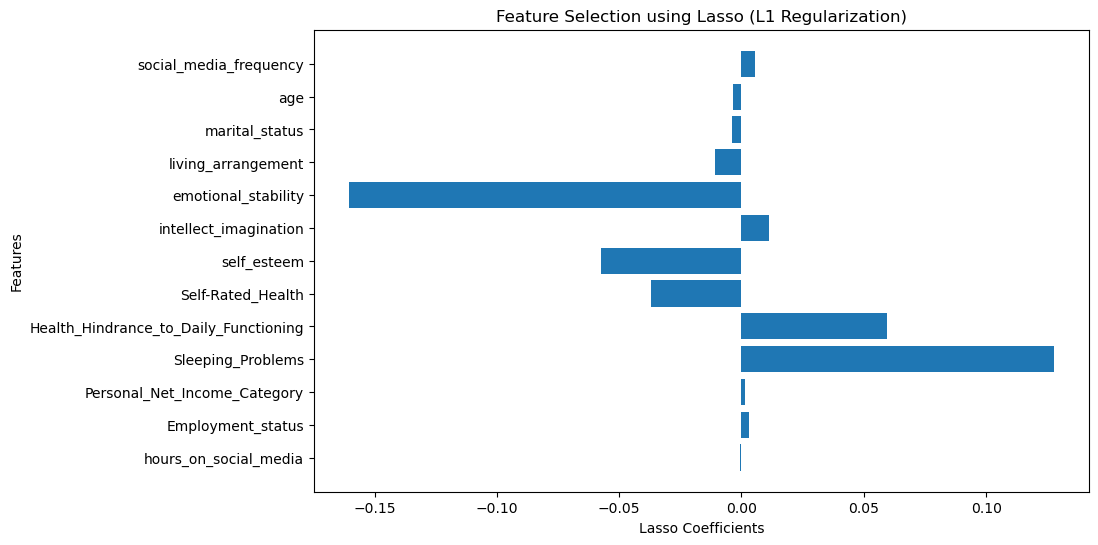

In [19]:
# Plot the coefficients (non-zero ones)
plt.figure(figsize=(10, 6))
plt.barh(selected_features_lasso['Feature'], selected_features_lasso['Coefficient'])
plt.xlabel("Lasso Coefficients")
plt.ylabel("Features")
plt.title("Feature Selection using Lasso (L1 Regularization)")
plt.gca().invert_yaxis()  # Highest coefficients on top
plt.show()


In [23]:
# extract the actual column names from selected_features_lasso
selected_feature_names = selected_features_lasso['Feature'].tolist()
#add id column
selected_feature_names_with_id = ['nomem_encr'] + selected_feature_names

final_df = df[selected_feature_names_with_id]
final_df.info()
final_df.to_csv('lasso_selected_features_with_id.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 994
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   nomem_encr                             994 non-null    int64  
 1   social_media_frequency                 985 non-null    float64
 2   age                                    994 non-null    float64
 3   marital_status                         994 non-null    float64
 4   living_arrangement                     994 non-null    float64
 5   emotional_stability                    994 non-null    float64
 6   intellect_imagination                  994 non-null    float64
 7   self_esteem                            993 non-null    float64
 8   Self-Rated_Health                      994 non-null    int64  
 9   Health_Hindrance_to_Daily_Functioning  993 non-null    float64
 10  Sleeping_Problems                      993 non-null    float64
 11  Personal_Ne